In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split

In [4]:
df = pd.read_csv('employee_churn_prediction_updated.csv')

In [5]:
# membuat kolom sementara
df['approx_start_age'] = df['age'] - df['experience_years']
unreasonable_start_age_data = df[df['approx_start_age'] < 18]

if unreasonable_start_age_data.empty:
    print("Tidak ada data anomali yang ditemukan dengan kriteria usia mulai bekerja < 18 tahun.")
else:
    # Menampilkan hanya kolom yang relevan agar mudah dibaca
    print("Ditemukan baris-baris berikut yang dianggap anomali:")
    print(unreasonable_start_age_data[['employee_id', 'age', 'experience_years', 'approx_start_age']])

Ditemukan baris-baris berikut yang dianggap anomali:
     employee_id  age  experience_years  approx_start_age
17            18   23                 8                15
20            21   23                 7                16
35            36   24                 7                17
70            71   23                 7                16
90            91   22                 9                13
..           ...  ...               ...               ...
959          960   22                 7                15
968          969   22                 8                14
981          982   22                 6                16
982          983   26                 9                17
999         1000   23                 6                17

[74 rows x 4 columns]


In [6]:
# PENANGANAN: Hapus baris anomali
initial_rows = len(df)
df = df[df['approx_start_age'] >= 18]
cleaned_rows = len(df)
print(f"\n[PENANGANAN] Anomali 2 telah ditangani: {initial_rows - cleaned_rows} baris dengan usia/pengalaman tidak logis telah dihapus.")


[PENANGANAN] Anomali 2 telah ditangani: 74 baris dengan usia/pengalaman tidak logis telah dihapus.


In [7]:
# Menghapus kolom bantu
df = df.drop(columns=['approx_start_age'])


Target column terdeteksi: 'churn'
churn
1    585
0    341
Name: count, dtype: int64


C:\Users\taufi\AppData\Local\Temp\ipykernel_17356\1915858118.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


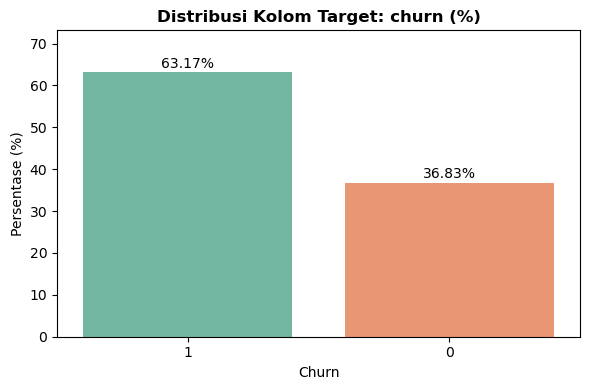

In [8]:
# IDENTIFIKASI TARGET DAN CEK DISTRIBUSINYA
target_col = 'churn'

if target_col in df.columns:
    print(f"\nTarget column terdeteksi: '{target_col}'")

    # Hitung distribusi dalam jumlah
    target_counts = df[target_col].value_counts()
    print(target_counts)

    # Hitung distribusi dalam persen
    target_pct = df[target_col].value_counts(normalize=True) * 100

    # Visualisasi distribusi target dalam persen
    plt.figure(figsize=(6, 4))
    sns.barplot(
        x=target_pct.index.astype(str),
        y=target_pct.values,
        palette="Set2"   # Warna berbeda untuk tiap bar
    )

    plt.title(f"Distribusi Kolom Target: {target_col} (%)", fontsize=12, weight='bold')
    plt.xlabel(target_col.capitalize())
    plt.ylabel("Persentase (%)")
    plt.ylim(0, target_pct.max() + 10)  # Tambahkan ruang untuk label di atas bar
    plt.xticks(rotation=0)

    # Tambahkan label persen di atas tiap bar
    for i, val in enumerate(target_pct.values):
        plt.text(i, val + 1, f"{val:.2f}%", ha='center', fontsize=10)

    plt.tight_layout()
    plt.show()

else:
    print("❌ Kolom target tidak ditemukan, silakan tentukan secara manual.")

In [9]:
# Pisahkan fitur numerik dan kategorikal, dengan pengecualian kolom tertentu
numeric_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = df.select_dtypes(include=['object', 'category']).columns.tolist()

# Keluarkan kolom yang tidak relevan dari masing-masing list
if 'employee_id' in numeric_features:
    numeric_features.remove('employee_id')

if 'churn_period' in categorical_features:
    categorical_features.remove('churn_period')

# Tampilkan hasil akhir untuk verifikasi
print("Fitur numerik:", numeric_features)
print("Fitur kategorikal:", categorical_features)

Fitur numerik: ['age', 'experience_years', 'monthly_target', 'target_achievement', 'working_hours_per_week', 'overtime_hours_per_week', 'salary', 'commission_rate', 'job_satisfaction', 'manager_support_score', 'company_tenure_years', 'churn', 'distance_to_office_km']
Fitur kategorikal: ['gender', 'education', 'work_location', 'marital_status']


In [10]:
X = df.drop(columns=[target_col, 'employee_id', 'churn_period'], errors='ignore')
y = df[target_col]

X_encoded = X.copy()
for col in categorical_features:
    if col in X_encoded.columns:  # pastikan kolom masih ada di fitur
        X_encoded[col] = LabelEncoder().fit_transform(X_encoded[col])

In [11]:
# OVERTIME RATIO
# Measures how much of total weekly working time is spent in overtime.
df['overtime_ratio'] = df['overtime_hours_per_week'] / df['working_hours_per_week']

# BURNOUT SCORE
# Combines overtime intensity and low job satisfaction into a single stress metric.
df['burnout_score'] = df['overtime_ratio'] * (1 - df['job_satisfaction'] / 5)

# ACHIEVEMENT STRESS
# Captures the frustration of working overtime but still missing targets.
df['achievement_stress'] = (1 - df['target_achievement']) * df['overtime_ratio']
df['achievement_stress'] = df['achievement_stress'].clip(lower=0)  # No negative stress

# ACHIEVE STATUS (binary)
# Indicates whether the employee met or exceeded their performance target.
df['achieve_status'] = (df['target_achievement'] >= 1).astype(int)

# LOYALTY INDEX
# Represents the proportion of an employee's total career spent at the company.
df['loyalty_index'] = df['company_tenure_years'] / (df['experience_years'] + 1)

# DISTANCE STRESS (adjusted by marital status)
# Reflects commuting stress, adjusted for family obligations and manager support.
df['distance_stress'] = df['distance_to_office_km'] / (df['manager_support_score'] + 1)

def adjust_distance_stress(row):
    if row['marital_status'] == 'Married':
        return row['distance_stress'] * 1.2
    else:
        return row['distance_stress'] * 1

df['distance_stress_adjusted'] = df.apply(adjust_distance_stress, axis=1)

# PROMOTION POTENTIAL
# Balances job satisfaction, performance, and tenure using a log scale to reduce saturation.
df['promotion_potential'] = (df['job_satisfaction'] + 2 * df['target_achievement']) * np.log(df['company_tenure_years'] + 1)

# STRESS INDEX
# Overall stress index combining workload, performance pressure, and commute strain.
# 0.01 scaling keeps commuting influence proportional to other stress sources.
df['stress_index'] = df['burnout_score'] + df['achievement_stress'] + 0.01 * df['distance_stress_adjusted']

# CHECK RESULTS
feature_cols = [
    'overtime_ratio', 'burnout_score', 'achievement_stress', 'achieve_status',
    'loyalty_index', 'distance_stress_adjusted', 'promotion_potential', 'stress_index'
]

# Show statistical summary
display(df[feature_cols].describe())

,overtime_ratio,burnout_score,achievement_stress,achieve_status,loyalty_index,distance_stress_adjusted,promotion_potential,stress_index
count,926.000000,926.000000,926.000000,926.000000,926.000000,926.000000,926.000000,926.000000
mean,0.177736,0.088896,0.041487,0.240821,0.786133,8.228567,4.870974,0.212669
std,0.111940,0.073737,0.049678,0.427813,0.880231,5.913164,2.415961,0.119043
min,0.000000,0.000000,0.000000,0.000000,0.012500,0.240000,0.285931,0.002400
25%,0.086957,0.031484,0.000000,0.000000,0.275000,3.616667,3.083590,0.122438
50%,0.170732,0.070088,0.022743,0.000000,0.500000,7.100000,4.696336,0.190986
75%,0.262295,0.128429,0.066846,0.000000,0.900000,11.000000,6.712037,0.279642
max,0.463415,0.361905,0.256500,1.000000,4.900000,29.400000,10.784519,0.751500


In [12]:
if 'distance_stress' in df.columns:
    df.drop(columns=['distance_stress'], inplace=True)
    print("🗑️ Dropped column: distance_stress")

🗑️ Dropped column: distance_stress


In [13]:
# Define categorical columns
categorical_cols = ['gender', 'education', 'work_location', 'marital_status']

# Make a copy to avoid modifying the original DataFrame
df_encoded = df.copy()

# Apply Label Encoding to each categorical column
le = LabelEncoder()
for col in categorical_cols:
    df_encoded[col] = le.fit_transform(df_encoded[col])

print("Number of columns before encoding:", df.shape[1])
print("Number of columns after encoding:", df_encoded.shape[1])

Number of columns before encoding: 27
Number of columns after encoding: 27


In [14]:
from sklearn.preprocessing import StandardScaler

numeric_cols = df_encoded.select_dtypes(include=['int64', 'float64']).columns.tolist()
if 'churn' in numeric_cols:
    numeric_cols.remove('churn')

scaler = StandardScaler()

df_scaled = df_encoded.copy()
df_scaled[numeric_cols] = scaler.fit_transform(df_encoded[numeric_cols])

display(df_scaled[numeric_cols].head())

,employee_id,age,experience_years,monthly_target,target_achievement,working_hours_per_week,overtime_hours_per_week,salary,commission_rate,job_satisfaction,manager_support_score,company_tenure_years,distance_to_office_km,overtime_ratio,burnout_score,achievement_stress,loyalty_index,distance_stress_adjusted,promotion_potential,stress_index
0,-1.744882,-0.859643,-1.497004,0.627739,0.654081,0.904231,-0.075154,-0.579022,-1.239683,1.325757,0.418455,0.146960,-0.153886,-0.291162,-0.812293,-0.660153,2.289123,-0.275563,1.233647,-0.915514
1,-1.741414,1.131962,0.620988,1.425582,-1.099223,0.097566,-0.250009,0.243820,0.052080,0.433569,0.418455,0.075674,0.847108,-0.288541,-0.416759,0.512004,-0.455147,0.130531,0.193412,0.020359
2,-1.737946,0.365960,1.326986,0.764512,-1.537549,0.558518,0.099701,-0.499798,0.482667,-1.350807,-0.482683,-0.637185,-0.511384,-0.073694,0.633644,1.076058,-0.678875,-0.433488,-1.243929,0.626217
3,-1.734478,-0.246841,0.973987,1.357196,-0.573232,1.595658,0.973976,-1.302076,-0.378508,-1.350807,-0.482683,-1.492615,0.561110,0.383016,1.188314,0.674958,-0.822539,0.773512,-1.627683,1.401948
4,-1.731010,-0.706442,0.973987,0.376988,0.960909,-1.054812,-0.075154,-0.241105,0.913255,0.433569,-0.482683,1.358819,-0.725883,0.198995,-0.120706,-0.835568,-0.254199,-0.602693,1.526868,-0.722834


In [15]:
cols_to_drop = ['employee_id', 'churn_period']
df_model = df_scaled.drop(columns=cols_to_drop, errors='ignore')

print("Data prepared for modeling (df_model).")
print(f"Shape of df_model: {df_model.shape}")

Data prepared for modeling (df_model).
Shape of df_model: (926, 25)


In [16]:
from sklearn.model_selection import train_test_split

x = df_model.drop(columns=['churn'])
y = df_model['churn']

x_train, x_test, y_train, y_test = train_test_split(
            x, y,
            test_size=0.2,
            random_state=42,
            stratify=y)

print("Training set shape :", x_train.shape)
print("Testing set shape  :", x_test.shape)

Training set shape : (740, 24)
Testing set shape  : (186, 24)


In [17]:
from imblearn.over_sampling import SMOTE
from collections import Counter

print("Distribusi sebelum SMOTE:")
print(Counter(y_train))

smote = SMOTE(random_state=42, sampling_strategy='auto')
x_train_resampled, y_train_resampled = smote.fit_resample(x_train, y_train)

print("\nDistribusi setelah SMOTE:")
print(Counter(y_train_resampled))

print(f"\nJumlah data sebelum SMOTE: {len(y_train)}")
print(f"Jumlah data setelah SMOTE : {len(y_train_resampled)}")

Distribusi sebelum SMOTE:
Counter({1: 467, 0: 273})

Distribusi setelah SMOTE:
Counter({1: 467, 0: 467})

Jumlah data sebelum SMOTE: 740
Jumlah data setelah SMOTE : 934


In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, classification_report, confusion_matrix
)

log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(x_train_resampled, y_train_resampled)

y_train_pred = log_reg.predict(x_train_resampled)
y_train_prob = log_reg.predict_proba(x_train_resampled)[:, 1]
train_acc = accuracy_score(y_train_resampled, y_train_pred)
train_prec = precision_score(y_train_resampled, y_train_pred)
train_rec = recall_score(y_train_resampled, y_train_pred)
train_f1 = f1_score(y_train_resampled, y_train_pred)

y_test_pred = log_reg.predict(x_test)
y_test_prob = log_reg.predict_proba(x_test)[:, 1]
test_acc = accuracy_score(y_test, y_test_pred)
test_prec = precision_score(y_test, y_test_pred)
test_rec = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)

print("===== Logistic Regression Model Evaluation =====\n")
print("🔹 TRAINING PERFORMANCE")
print(f"Accuracy  : {train_acc:.4f}")
print(f"Precision : {train_prec:.4f}")
print(f"Recall    : {train_rec:.4f}")
print(f"F1-Score  : {train_f1:.4f}\n")
    
print("\n🔹 TESTING PERFORMANCE")
print(f"Accuracy  : {test_acc:.4f}")
print(f"Precision : {test_prec:.4f}")
print(f"Recall    : {test_rec:.4f}")
print(f"F1-Score  : {test_f1:.4f}\n")

print("\n===== Classification Report (Testing Set) =====")
print(classification_report(y_test, y_test_pred, digits=4))


===== Logistic Regression Model Evaluation =====

🔹 TRAINING PERFORMANCE
Accuracy  : 0.7580
Precision : 0.7591
Recall    : 0.7559
F1-Score  : 0.7575


🔹 TESTING PERFORMANCE
Accuracy  : 0.6989
Precision : 0.8100
Recall    : 0.6864
F1-Score  : 0.7431


===== Classification Report (Testing Set) =====
              precision    recall  f1-score   support

           0     0.5698    0.7206    0.6364        68
           1     0.8100    0.6864    0.7431       118

    accuracy                         0.6989       186
   macro avg     0.6899    0.7035    0.6897       186
weighted avg     0.7222    0.6989    0.7041       186



In [21]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV

df_pos = df_encoded.copy()
to_flip = ['manager_support_score', 'marital_status', 'target_achievement', 'promotion_potential']
for col in to_flip:
    df_pos[col] = df_pos[col].max() - df_pos[col]

selected_features = [
    'achieve_status',
    'company_tenure_years',
    'distance_to_office_km',
    'working_hours_per_week',
    'manager_support_score',
    'marital_status',
    'target_achievement',
    'promotion_potential'
]
target_column = 'churn'

x = df_pos[selected_features]
y = df_pos[target_column]

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42, stratify=y
)

print("Distribusi sebelum SMOTE:", Counter(y_train))

smote = SMOTE(random_state=42, sampling_strategy='auto')
x_train_resampled,y_train_resampled = smote.fit_resample(x_train, y_train)
print("Distribusi setelah SMOTE:", Counter(y_train_resampled))

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train_resampled)
x_test_scaled = scaler.transform(x_test)

x_train_scaled_df = pd.DataFrame(x_train_scaled, columns=selected_features)
x_test_scaled_df = pd.DataFrame(x_test_scaled, columns=selected_features)

param_dist = {
    'C': np.logspace(-3, 10, 50),
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']
}

log_reg = LogisticRegression(max_iter=2000, random_state=42)

random_search = RandomizedSearchCV(
    estimator=log_reg,
    param_distributions=param_dist,
    n_iter=30,
    scoring='recall',
    cv=5,
    n_jobs=-1,
    verbose=2,
    random_state=42
)

random_search.fit(x_train_scaled_df, y_train_resampled)

print("\n===== 🔍 Best Logistic Regression Hyperparameters =====")
print(random_search.best_params_)
print(f"Best CV Recall: {random_search.best_score_:.4f}\n")

best_log_reg = random_search.best_estimator_

y_train_pred = best_log_reg.predict(x_train_scaled_df)
y_test_pred = best_log_reg.predict(x_test_scaled_df)

train_acc = accuracy_score(y_train_resampled, y_train_pred)
train_prec = precision_score(y_train_resampled, y_train_pred)
train_rec = recall_score(y_train_resampled, y_train_pred)
train_f1 = f1_score(y_train_resampled, y_train_pred)

test_acc = accuracy_score(y_test, y_test_pred)
test_prec = precision_score(y_test, y_test_pred)
test_rec = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)

print("===== Logistic Regression Model Evaluation (After Random Search) =====\n")
print("🔹 TRAINING PERFORMANCE")
print(f"Accuracy  : {train_acc:.4f}")
print(f"Precision : {train_prec:.4f}")
print(f"Recall    : {train_rec:.4f}")
print(f"F1-Score  : {train_f1:.4f}")

print("\n🔹 TESTING PERFORMANCE")
print(f"Accuracy  : {test_acc:.4f}")
print(f"Precision : {test_prec:.4f}")
print(f"Recall    : {test_rec:.4f}")
print(f"F1-Score  : {test_f1:.4f}")

print("\n===== Classification Report (Testing Set) =====")
print(classification_report(y_test, y_test_pred, digits=4))


Distribusi sebelum SMOTE: Counter({1: 467, 0: 273})
Distribusi setelah SMOTE: Counter({1: 467, 0: 467})
Fitting 5 folds for each of 30 candidates, totalling 150 fits

===== 🔍 Best Logistic Regression Hyperparameters =====
{'solver': 'saga', 'penalty': 'l1', 'C': 0.8286427728546851}
Best CV Recall: 0.7880

===== Logistic Regression Model Evaluation (After Random Search) =====

🔹 TRAINING PERFORMANCE
Accuracy  : 0.7891
Precision : 0.7909
Recall    : 0.7859
F1-Score  : 0.7884

🔹 TESTING PERFORMANCE
Accuracy  : 0.7366
Precision : 0.8286
Recall    : 0.7373
F1-Score  : 0.7803

===== Classification Report (Testing Set) =====
              precision    recall  f1-score   support

           0     0.6173    0.7353    0.6711        68
           1     0.8286    0.7373    0.7803       118

    accuracy                         0.7366       186
   macro avg     0.7229    0.7363    0.7257       186
weighted avg     0.7513    0.7366    0.7404       186



In [28]:
df[selected_features].sample(10)

,achieve_status,company_tenure_years,distance_to_office_km,working_hours_per_week,manager_support_score,marital_status,target_achievement,promotion_potential
876,0,4.4,17,40,2,Married,0.96,8.297083
414,0,3.5,31,43,3,Single,0.76,3.790275
459,0,4.6,12,64,4,Married,0.84,6.339781
450,0,3.7,4,49,3,Single,0.96,9.161570
21,0,2.1,29,51,3,Single,0.49,2.240176
801,0,1.5,22,56,1,Married,0.92,4.434847
971,0,3.1,11,43,2,Single,0.59,5.897926
83,0,0.1,34,48,3,Single,0.56,0.487988
245,1,4.3,21,55,4,Single,1.06,5.203245
195,1,4.0,45,68,4,Married,1.01,4.860502


In [22]:
import joblib

joblib.dump(best_log_reg, 'model_churn.pkl')
joblib.dump(scaler, 'scaler.pkl')


['scaler.pkl']